In [94]:
# Imported necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr

In [95]:
# Get tickers of all SP500 stocks
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tickers = pd.read_html(io=url)[0]['Symbol'].to_list()
tickers = [t.replace('.', '-') for t in tickers]

In [116]:
# Function to get data stocks of sp500

def get_data(tickers, index, start, end, file):
    (yf.download(tickers=tickers, start=start, end=end)['Adj Close']
     .pct_change()
     .join(other=(yf.download(tickers=index, start='1900-01-01', end=end)
                  [['Close']].rename(columns={'Close': index}))
                  ,how='outer').to_csv(file))
get_data(tickers=tickers, index='^GSPC', start='1980-01-01', end='2023-12-31', file ='/Users/nilkanthpatel/Desktop/sp500.csv')

sp500 = (
    pd.read_csv(
        filepath_or_buffer='/Users/nilkanthpatel/Desktop/sp500.csv',
        parse_dates=['Date'],
        index_col=['Date']
    )
    .rename_axis(columns='Ticker')
)

/Users/nilkanthpatel/anaconda3/envs/fina6339/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/Users/nilkanthpatel/anaconda3/envs/fina6339/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/nilkanthpatel/anaconda3/envs/fina6339/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/nilkanthpatel/anaconda3/envs/fina6339/li

In [ ]:
# Download fama french data for riskfree rate

ff_all = pdr.DataReader(
    name='F-F_Research_Data_Factors_daily',
    data_source='famafrench',
    start='1900',
    end = '2024'
)
ff_data = ff_all[0]

In [110]:
# Function to calculate and merge consecutive bearish and bullish periods

start_date =  '1980-01-01'
end_date = '2023-12-29'
snp500 =pd.DataFrame(sp500['^GSPC'].loc[start_date:end_date])

def calculate_merge_periods(df, window='M'):
    df = df.resample(window).last()
    df['returns'] = df['^GSPC'].pct_change()
    df['cumulative'] = (1 + df['returns']).cumprod()
    df['peak'] = df['cumulative'].cummax()
    df['trough'] = df['cumulative'].cummin()
    df['drawdown'] = (df['cumulative'] / df['peak']) - 1
    df['runup'] = (df['cumulative'] / df['trough']) - 1

    bear_periods = []
    bull_periods = []

    is_bear = False
    period_start = df.index[0]

    for i in range(1, len(df)):
        if df['drawdown'].iloc[i] <= -0.20:
            if not is_bear:
                if period_start != df.index[i]:
                    bull_periods.append((period_start, df.index[i]))
                period_start = df.index[i]
                is_bear = True
        elif df['runup'].iloc[i] >= 0.20:
            if is_bear:
                bear_periods.append((period_start, df.index[i]))
                period_start = df.index[i]
                is_bear = False

    # Add the last period if the loop ends while in a period
    if is_bear:
        bear_periods.append((period_start, df.index[-1]))
    else:
        bull_periods.append((period_start, df.index[-1]))
    
    bull_df = pd.DataFrame(bull_periods,columns=['start','end'])
    bear_df = pd.DataFrame(bear_periods,columns=['start','end'])

    return bear_df, bull_df

monthly_bear, monthly_bull = calculate_merge_periods(snp500, window='M')

/var/folders/q7/rl1ql8s51w7g6407mjltrv0r0000gn/T/ipykernel_76075/2697816757.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(window).last()


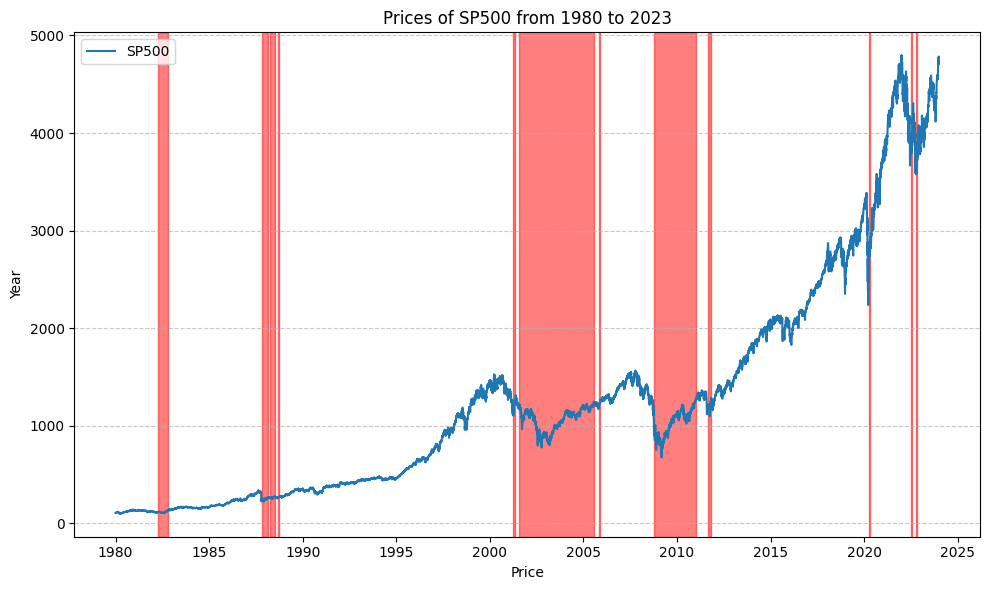

In [112]:
# Plot of Prices of SP500 from 1980 to 2023 highlighting crisis period.

plt.figure(figsize=(10,6))
plt.plot(snp500)
for i in range(len(monthly_bear)):
    start =  monthly_bear.at[i,'start']
    end =  monthly_bear.at[i,'end']
    plt.axvspan(start,end,color = 'red',alpha = 0.5)
plt.xlabel('Price')
plt.ylabel('Year')
plt.legend(['SP500'])
plt.title('Prices of SP500 from 1980 to 2023')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show
plt.show()


In [140]:
# Function to analyze periods and calculate mean and median correlations

def analyze_correlation(period_df,stock_data):
    descriptive_stats = pd.DataFrame(period_df)
    for i in range(len(period_df)):
        start =  descriptive_stats.at[i,'start']
        end =  descriptive_stats.at[i,'end']
        period_data = stock_data.loc[start:end]

        valid_stocks = period_data.dropna(axis=1, how='any')

        corr_matrix = valid_stocks.corr()
        corr_values = corr_matrix.values.flatten()

        corr_values = corr_values[~np.isnan(corr_values) & (corr_values != 1)]
        descriptive_stats.at[i,'mean_corr'] = np.mean(corr_values)
        descriptive_stats.at[i,'median_corr'] = np.median(corr_values)
    return descriptive_stats

/var/folders/q7/rl1ql8s51w7g6407mjltrv0r0000gn/T/ipykernel_76075/1170337050.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_dates = pd.date_range(start=start_date, end=end_date, freq='M')
/var/folders/q7/rl1ql8s51w7g6407mjltrv0r0000gn/T/ipykernel_76075/1170337050.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_subset.drop(columns=['^GSPC'], inplace=True)


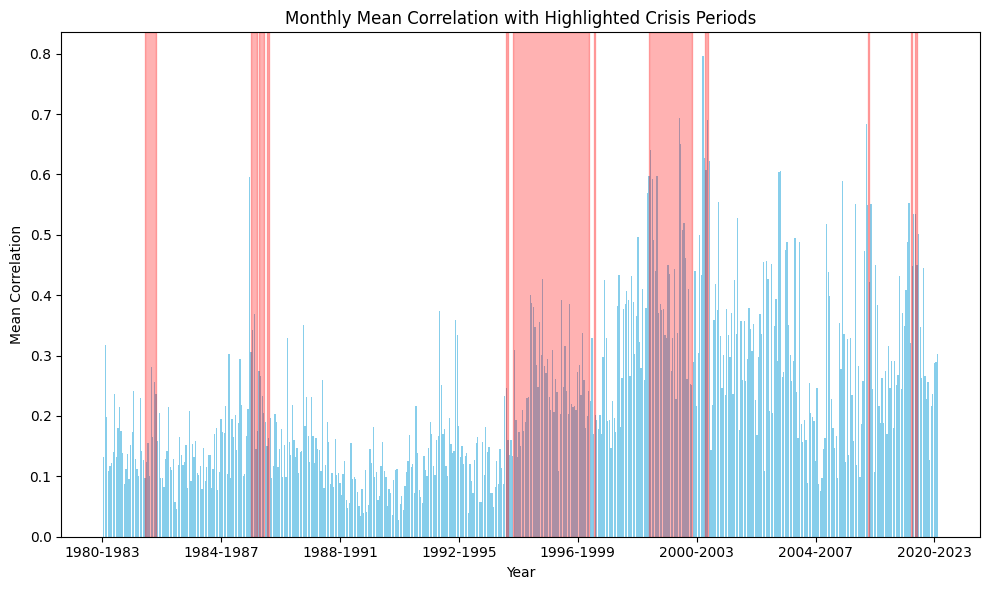

In [143]:
# Trend in monthly correlation of all stocks and highlighting crisis period

start_date = '1980-01-01'
end_date = '2023-12-31'
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='M')

stock_data_subset =  sp500.loc[start_date:end_date]
stock_data_subset.drop(columns=['^GSPC'], inplace=True)

all_periods = []
for i in range(len(monthly_dates) - 1):
    start_period = monthly_dates[i].strftime('%Y-%m-%d')
    end_period = monthly_dates[i + 1].strftime('%Y-%m-%d')
    all_periods.append((start_period, end_period))
all_periods =  pd.DataFrame(all_periods,columns=['start','end'])

all_corr =  analyze_correlation(all_periods,stock_data_subset)
all_corr

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(all_corr) + 1), all_corr['mean_corr'], color='skyblue')
for index, row in monthly_bear.iterrows():
    start_index = monthly_dates.get_loc(row['start']) + 1
    end_index = monthly_dates.get_loc(row['end']) + 1
    plt.axvspan(start_index, end_index, color='red', alpha=0.3)

step_size = (len(all_corr) - 1) // 7
custom_ticks = [i * step_size for i in range(8)]
custom_labels = [f'{1980 + i * 4}-{1983 + i * 4}' if i < 7 else '2020-2023' for i in range(8)]
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Year')
plt.ylabel('Mean Correlation')
plt.title('Monthly Mean Correlation with Highlighted Crisis Periods')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

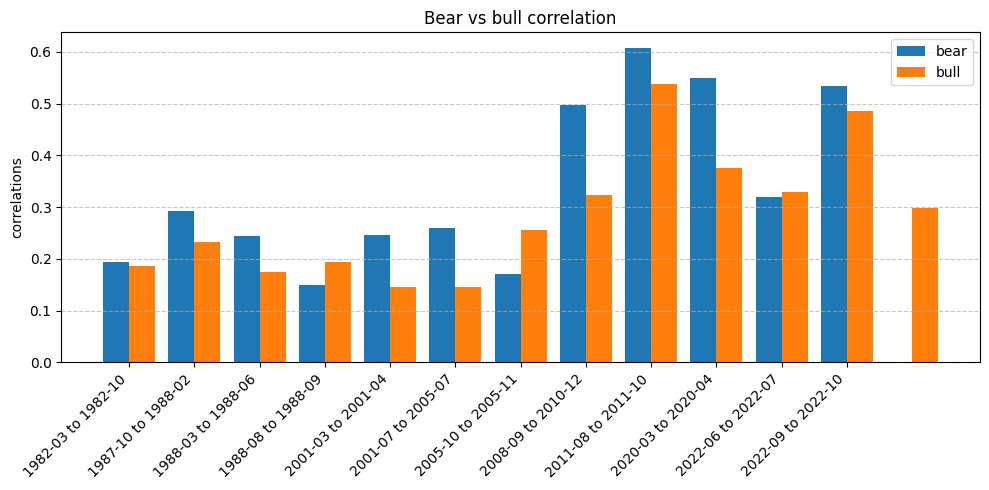

In [142]:
# Using above function to get mean correlation and plot of stocks in Bear vs Bull periods

bear_corr = analyze_correlation(monthly_bear, stock_data_subset)
bull_corr = analyze_correlation(monthly_bull, stock_data_subset)

x = np.arange(len(bear_corr))
y = np.arange(len(bull_corr))
width = 0.4
plt.figure(figsize=(10,5))
plt.bar(x-0.2,bear_corr['mean_corr'],width)
plt.bar(y+0.2,bull_corr['mean_corr'],width)
plt.ylabel('correlations')
tick_positions = np.arange(len(monthly_bear))
tick_labels = [f"{start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}" for start, end in zip(monthly_bear['start'], monthly_bear['end'])]
plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")
plt.legend(["bear","bull"])
plt.title('Bear vs bull correlation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show

In [104]:
# Function to analyse beta of all stocks during crisis period

def analyse_beta(period_df,stock_data,ff_data):
    beta = pd.DataFrame(period_df)
    for i in range(len(period_df)):
        start =  beta.at[i,'start']
        end =  beta.at[i,'end']
        period_data =  stock_data[start:end]
        ff =  ff_data[start:end]
        market_excess = period_data['^GSPC'].pct_change() - ff['RF']
        var = market_excess.var()
        for tickers in period_data:
            if tickers != '^GSPC':
                stock_excess = period_data[tickers] - ff['RF']
                covar = stock_excess.cov(market_excess)
                beta.at[i,tickers] = covar/var
    return beta
            
beta_bear = analyse_beta(monthly_bear,sp500,ff_data)
beta_bear['mean'] = beta_bear.iloc[:, 2:].apply(lambda row: row.mean(skipna=True), axis=1)

beta_bull = analyse_beta(monthly_bull,sp500,ff_data)
beta_bull['mean'] = beta_bull.iloc[:, 2:].apply(lambda row: row.mean(skipna=True), axis=1)

/var/folders/q7/rl1ql8s51w7g6407mjltrv0r0000gn/T/ipykernel_76075/2864269160.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  beta.at[i,tickers] = covar/var
/var/folders/q7/rl1ql8s51w7g6407mjltrv0r0000gn/T/ipykernel_76075/2864269160.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  beta.at[i,tickers] = covar/var
/var/folders/q7/rl1ql8s51w7g6407mjltrv0r0000gn/T/ipykernel_76075/2864269160.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

<function matplotlib.pyplot.show(close=None, block=None)>

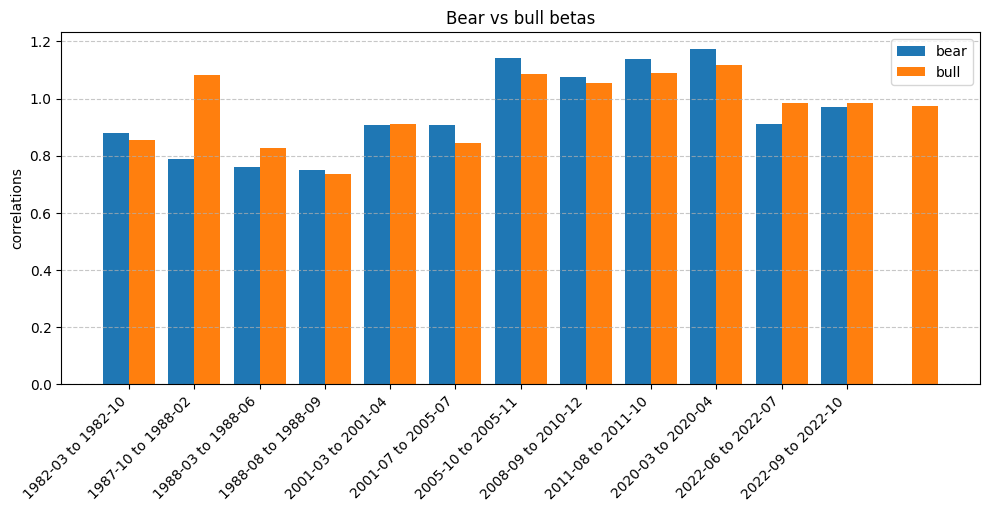

In [105]:
# plot of mean beta of stocks in Bear vs Bull periods

x = np.arange(len(beta_bear))
y = np.arange(len(beta_bull))
width = 0.4
plt.figure(figsize=(10,5))
plt.bar(x-0.2,beta_bear['mean'],width)
plt.bar(y+0.2,beta_bull['mean'],width)
tick_positions = np.arange(len(monthly_bear))
tick_labels = [f"{start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}" for start, end in zip(monthly_bear['start'], monthly_bear['end'])]
plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")
plt.ylabel('correlations')
plt.legend(["bear","bull"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('Bear vs bull betas')
plt.show